In [11]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Minimum Variance Portfolio Backtest.

In [12]:
import pandas as pd
from qamsi.config.trading_config import TradingConfig
from qamsi.runner import Runner
from qamsi.strategies.estimated.min_var import MinVariance
from qamsi.cov_estimators.cov_estimators import CovEstimators
from qamsi.features.preprocessor import Preprocessor
from run import Dataset

In [13]:
REBAL_FREQ = "ME"
DATASET = Dataset.SPX_US
ESTIMATION_WINDOW = 365 * 1

In [14]:
experiment_config = DATASET.value()

stocks = tuple(
    pd.read_csv(experiment_config.PATH_OUTPUT / experiment_config.STOCKS_LIST_FILENAME)
    .iloc[:, 0]
    .astype(str)
    .tolist(),
)
experiment_config.ASSET_UNIVERSE = stocks  # type: ignore  # noqa: PGH003

experiment_config.MIN_ROLLING_PERIODS = ESTIMATION_WINDOW + 1
experiment_config.N_LOOKBEHIND_PERIODS = None
experiment_config.REBALANCE_FREQ = REBAL_FREQ

factors = pd.read_csv(experiment_config.PATH_OUTPUT / "factors.csv")
factors["date"] = pd.to_datetime(factors["date"])
factors = factors.set_index("date")
factor_names = tuple(factors.columns.astype(str).tolist())
experiment_config.FACTORS = factor_names

prices = [stock + "_Price" for stock in list(stocks)]
preprocessor = Preprocessor(
    exclude_names=[
        *list(stocks),
        experiment_config.RF_NAME,
        *experiment_config.HEDGING_ASSETS,
        *factor_names,
        *prices,
    ],
)

trading_config = TradingConfig(
    broker_fee=0.05 / 100,
    bid_ask_spread=0.03 / 100,
    total_exposure=1,
    max_exposure=1,
    min_exposure=0,
    trading_lag_days=1,
)

runner = Runner(
    experiment_config=experiment_config,
    trading_config=trading_config,
    verbose=True,
)

Backtest on 2004-03-19 00:00:00 to 2023-12-29 00:00:00


In [15]:
ESTIMATOR = CovEstimators.MA.value(shrinkage_type="linear")

strategy = MinVariance(
    cov_estimator=ESTIMATOR,
    trading_config=trading_config,
    window_size=ESTIMATION_WINDOW,
)

strategy_name = ESTIMATOR.__class__.__name__

result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)
result

Num Train Iterations: 221


Computing Weights: 100%|██████████| 221/221 [00:28<00:00,  7.62it/s]


StrategyStatistics:
* final_nav = 4.133916
* geom_avg_total_r = 0.100724
* geom_avg_xs_r = 0.065684
* std_xs_r = 0.140197
* min_xs_r = -0.087968
* max_xs_r = 0.085931
* skew = -0.133073
* kurtosis = 22.143444
* max_dd = -0.300239
* sharpe = 0.468511
* alpha_buy_hold = 0.003435
* tracking_error_buy_hold = 0.129260
* ir_buy_hold = 0.026573
* factor_loadings = {'low_risk': 0.4561094031730869, 'momentum': 0.006916998522563576, 'quality': -0.020131170631384195, 'size': 0.08546085409101108, 'value': -0.10566051735951727, 'spx': 0.7062831738513672}
* alpha_benchmark = 0.012986
* alpha_benchmark_pvalue = 0.417606
* tracking_error_benchmark = 0.066764
* ir_benchmark = 0.194502
* ttest_pval = 0.565358
* levene_pval = 0.000000
* timing_ability_coef = -0.025108
* timing_ability_pval = 0.066627

In [16]:
result.std_xs_r

np.float64(0.14019650557608404)

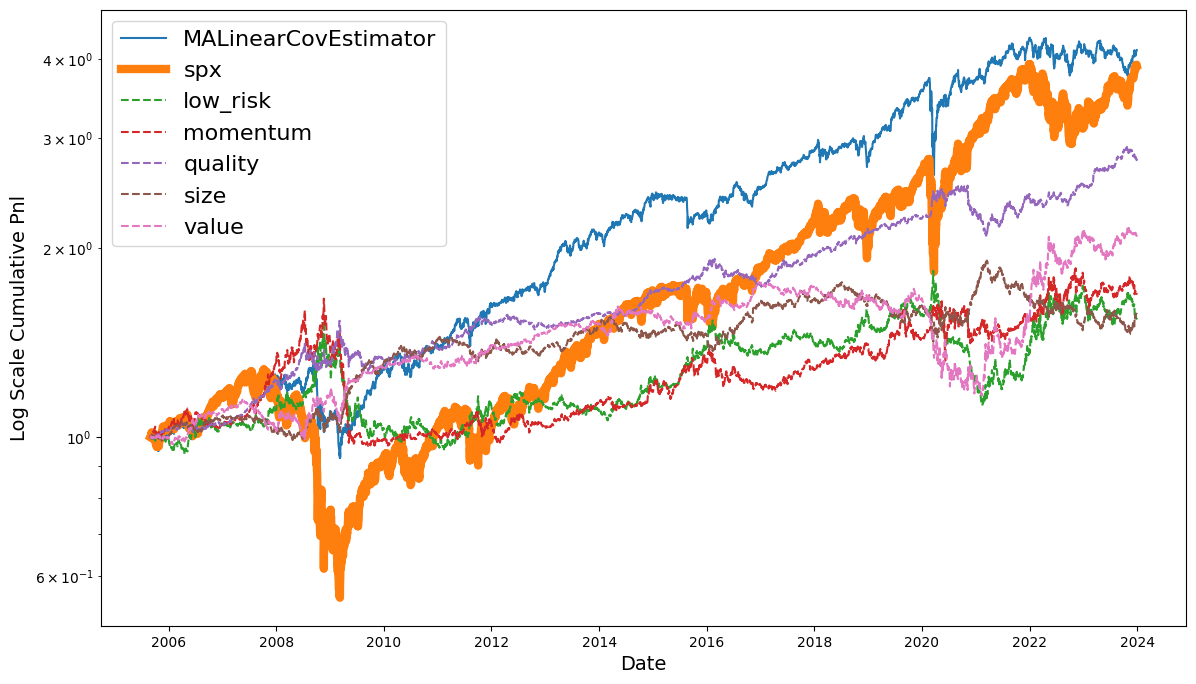

In [17]:
runner.plot_cumulative(
    strategy_name=strategy_name,
    include_factors=True,
)

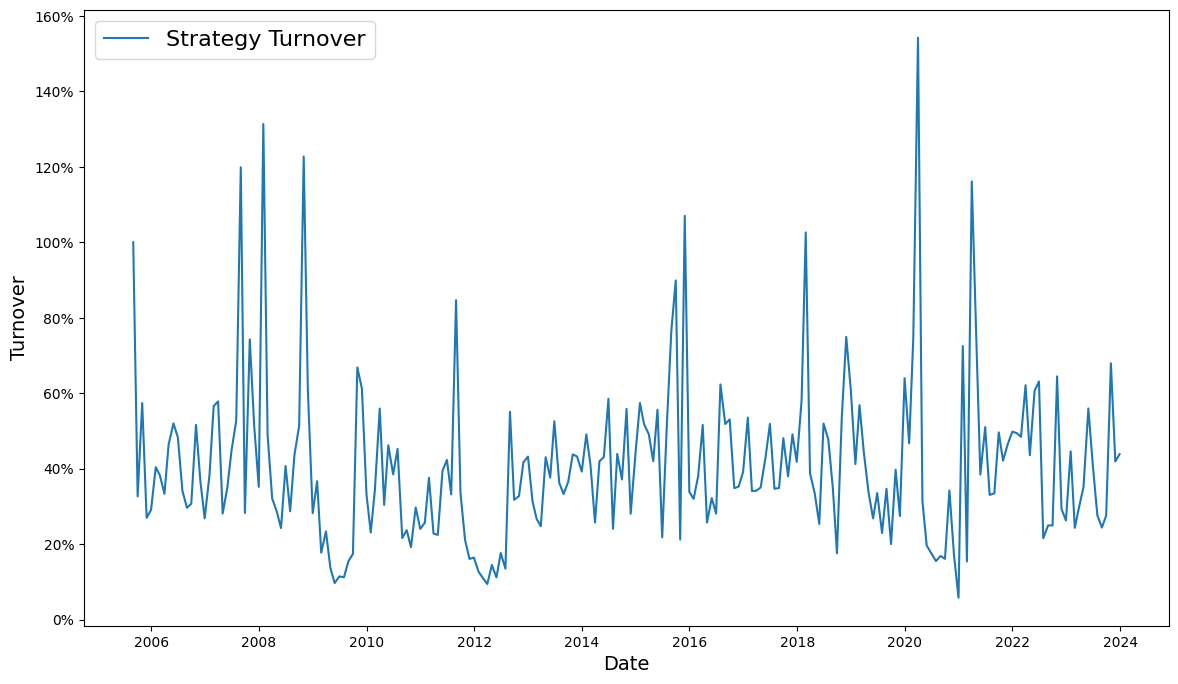

In [18]:
runner.plot_turnover()

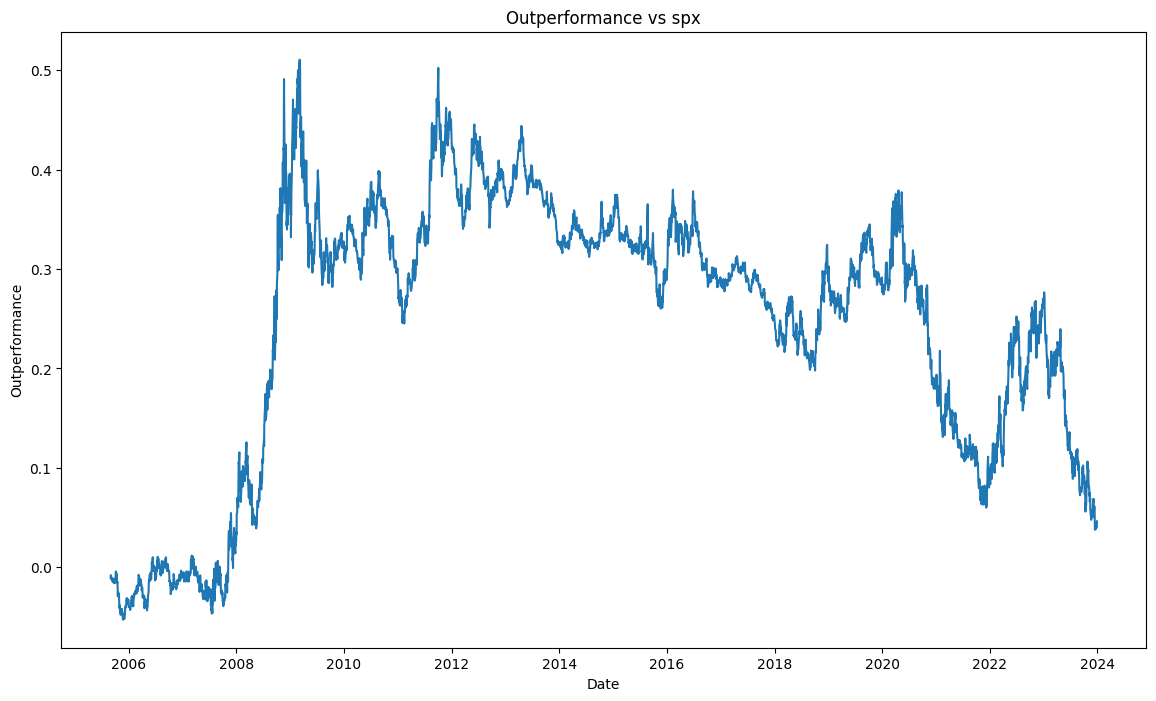

In [19]:
runner.plot_outperformance(mkt_only=True)

In [20]:
runner.save(DATASET.name + strategy_name + f"_rebal{REBAL_FREQ}")